<a href="https://colab.research.google.com/github/cubiwan/colabs_IA/blob/main/CLIPSeg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLIPSeg, segmentando imágenes con prompts

Demostración dl proyecto [CLIPSeg](https://github.com/timojl/clipseg).

Este colab es una versión de este otro [colab](https://colab.research.google.com/github/huggingface/blog/blob/main/notebooks/123_clipseg-zero-shot.ipynb)

Se intala Hugging Face Transformers

In [ ]:
!pip install -q transformers

Se descargan los modelos

In [ ]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

Usamos una imagen de pruebas. Creditos de [Calum Lewis](https://unsplash.com/@calumlewis).

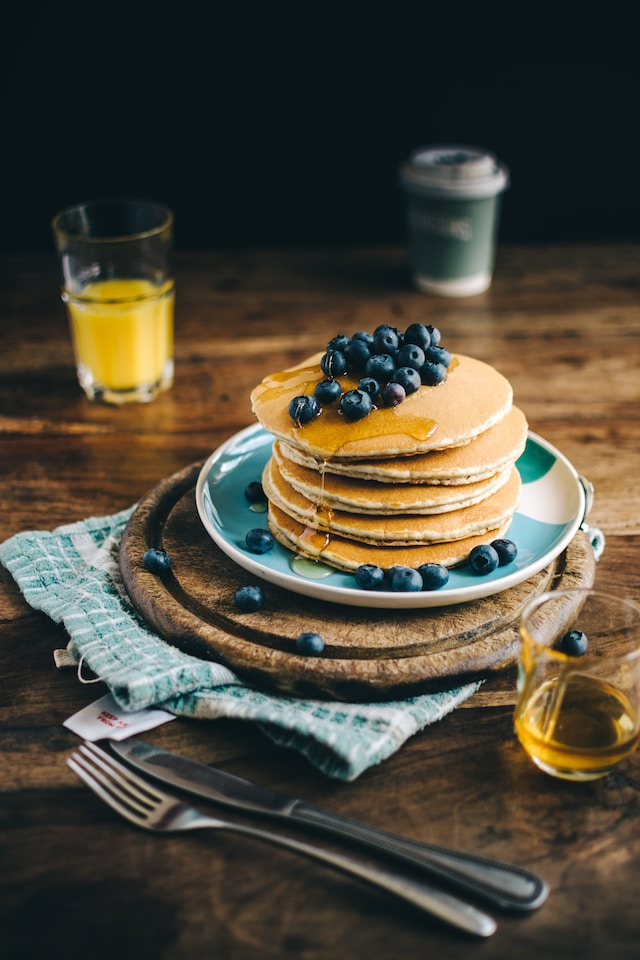

In [3]:
from PIL import Image
import requests

url = "https://unsplash.com/photos/8Nc_oQsc2qQ/download?ixid=MnwxMjA3fDB8MXxhbGx8fHx8fHx8fHwxNjcxMjAwNzI0&force=true&w=640"
image = Image.open(requests.get(url, stream=True).raw)
image

## Text prompting

Definimos los prompts de texto

In [7]:
#faciles
prompts = ["cutlery", "pancakes", "blueberries", "orange juice", "glass"]

#dificiles
#prompts = ["table", "airplane", "it breaks if it falls to the ground", "used for eating", "tool used for eating", "paper cup"]


Los procesamos

In [8]:
import torch

inputs = processor(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="pt")
# predict
with torch.no_grad():
  outputs = model(**inputs)
preds = outputs.logits.unsqueeze(1)

Visulizamos el resultado

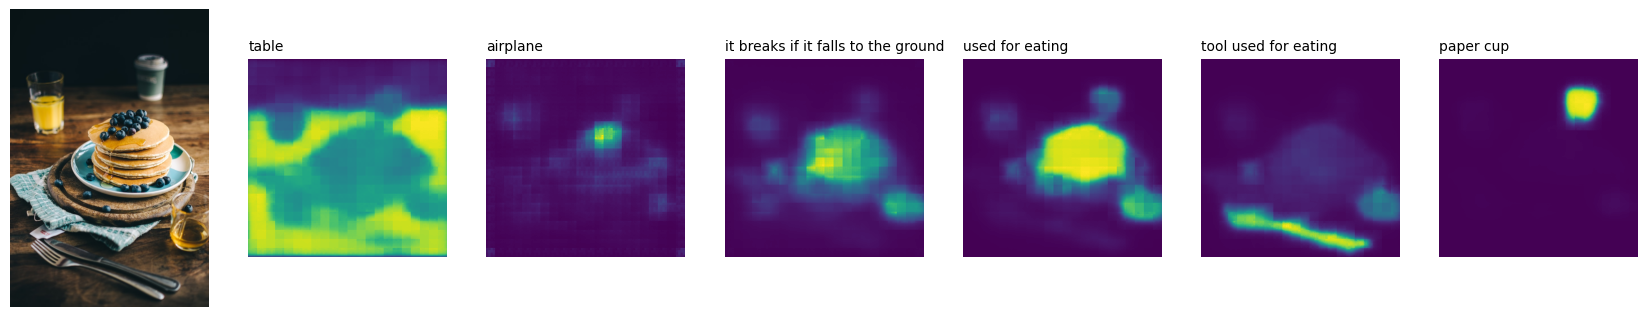

In [9]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(1, len(prompts) + 1, figsize=(3*(len(prompts) + 1), 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompt) for i, prompt in enumerate(prompts)];

## Visual prompting

Vamos a usar una imagen como prompt. En este caso una foto de un vaso de café de [Daniel Hooper](https://unsplash.com/@dan_fromyesmorecontent).


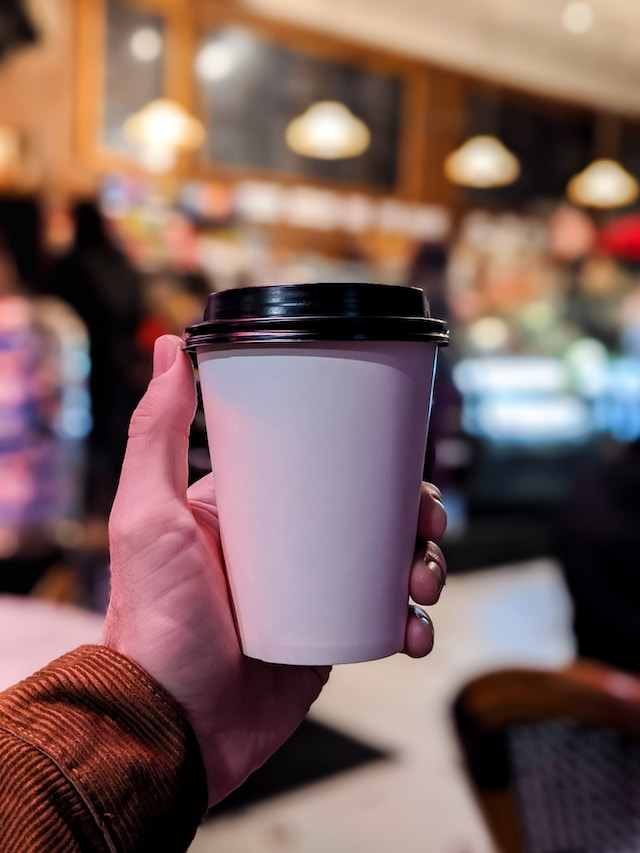

In [10]:
url = "https://unsplash.com/photos/Ki7sAc8gOGE/download?ixid=MnwxMjA3fDB8MXxzZWFyY2h8MTJ8fGNvZmZlJTIwdG8lMjBnb3xlbnwwfHx8fDE2NzExOTgzNDQ&force=true&w=640"
prompt = Image.open(requests.get(url, stream=True).raw)
prompt

Procesamos el prompt

In [11]:
encoded_image = processor(images=[image], return_tensors="pt")
encoded_prompt = processor(images=[prompt], return_tensors="pt")

# predict
with torch.no_grad():
  outputs = model(**encoded_image, conditional_pixel_values=encoded_prompt.pixel_values)
preds = outputs.logits.unsqueeze(1)
preds = torch.transpose(preds, 0, 1)

Visualizamos el resultado

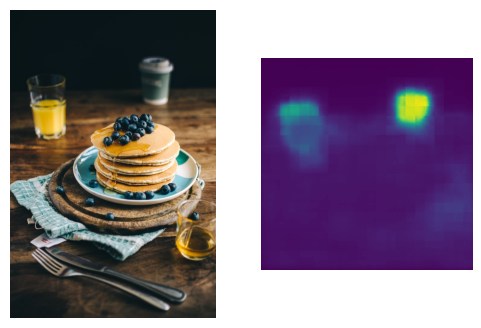

In [12]:
_, ax = plt.subplots(1, 2, figsize=(6, 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
ax[1].imshow(torch.sigmoid(preds[0]))

Ahora probamos con una versión modificada, donde la imagen ha sido recortada y el fondo oscurecido.

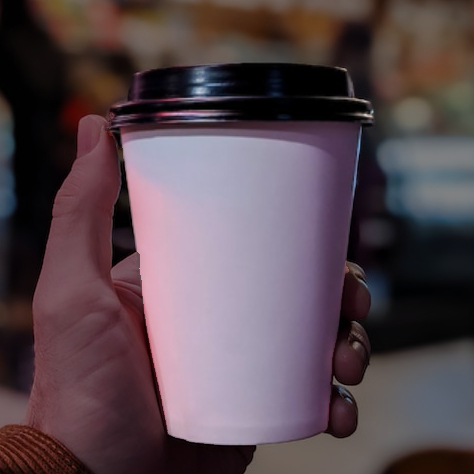

In [13]:
url = "https://i.imgur.com/mRSORqz.jpg"
alternative_prompt = Image.open(requests.get(url, stream=True).raw)
alternative_prompt


Procesamos el prompt

In [14]:
encoded_alternative_prompt = processor(images=[alternative_prompt], return_tensors="pt")
# predict
with torch.no_grad():
  outputs = model(**encoded_image, conditional_pixel_values=encoded_alternative_prompt.pixel_values)
preds = outputs.logits.unsqueeze(1)
preds = torch.transpose(preds, 0, 1)

Visulazamos el resultado

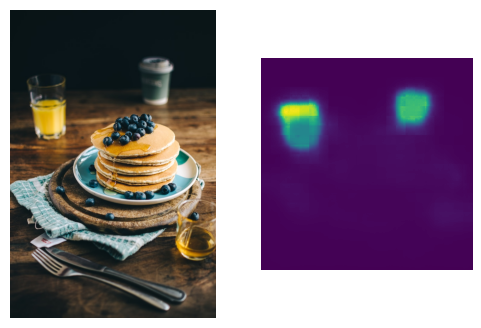

In [15]:
_, ax = plt.subplots(1, 2, figsize=(6, 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
ax[1].imshow(torch.sigmoid(preds[0]))